In [44]:
from dotenv import load_dotenv
from enum import Enum
import os
from rich.markdown import Markdown
from rich import print as md
from typing import Annotated, List, Sequence, TypedDict, Union
from langchain.output_parsers import PydanticOutputParser
import contextlib
import io
load_dotenv()
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
import operator
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.graph import END, StateGraph
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field

class Severity(Enum):
    CRITICAL = "Critical"
    MEDIUM = "Medium"
    LOW = "Low"

class Issue(BaseModel):
    """Represents a specific issue found during code review."""

    cell_position: int = Field(
        ..., description="The position of the cell where the issue was found."
    )
    what: str = Field(..., description="A brief description of the issue.")
    why: str = Field(..., description="Explanation of why this is an issue.")
    where: str = Field(
        ...,
        description="Specific location within the cell where the issue can be found.",
    )
    severity: Severity = Field(
        ...,
        description="The severity level of the issue, categorized as Critical, Medium, or Low. Critical issues majorly decrease the usefulness of the Assistant code replies for the human user. Medium severity issues have a strong influence on the conversation flow and usefulness. Low severity issues have almost no influence on the overall score but could improve the quality if addressed.",
    )
    fix: str = Field(
        ..., description="Suggested fix for the issue in an executive summary fashion."
    )


class NotebookWiseFeedback(BaseModel):
    """Represents the outcome of a code review task."""

    scratchpad: str = Field(
        ...,
        description="Place for you to think. Think before issues and score creation. Be concise. Analyze the text to achieve your goal. Always think before looking for issues!",
    )
    issues: list[Issue] = Field(
        ...,
        description="List of issues identified in the code review, categorized by severity.",
    )
    scoring_explanation: str = Field(
        ...,
        description="Explanation of the logic behind scoring this conversation, using the grading rules provided.",
    )
    score: int | None = Field(
        ...,
        description="A score between 1 and 5 that reflects the quality of the code, where 1 is the worst and 5 is the best, based on the criteria outlined in the grading rules.",
    )
    

#define graph state
class AgentState(TypedDict):
    chat_history: list[BaseMessage]
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_config:dict






main_prompt = """# IDENTITY

You are an AI named Codia. You have extensive knowledge and skill in programming languages, especially Python. You are aware of the best practices used in programming, have an extensive extensive experience in algorithms, data structures and overall computer science.

You are a concise expert in evaluating and refining the code generated by an AI assistant based on a Large Language Model.

# GOALS

Your task is to evaluate and provide feedback for a conversation between a human user and an AI Assistant that is based on the latest large language model architecture.
Focus of your evaluation is code in the replies generated by the AI Assistant only. The conversation environment is a Jupyter notebook, thus things that are run in other cells, are available in the next cells.

# RULES

Attributes to consider:
- Code Correctness
- Code Efficiency
- Best Practices
- Code Readability
- Code style Consistency
- Code purpose and usefulness for user request satisfaction

**1. Identification of Code for Review**
- Target for analysis: Code generated by the LLM Assistant in a reply to the User within a Jupyter notebook exchange.
- Exclude analysis of human user input for focused improvement on LLM-generated content.
- Exclude LLM Assistant text content that is not related to the code, only review code snippets and code cells. Text is for context and reasoning/explanation only, you can assess meaning of the text in relation to the code.
- Exclude concerns about code explanation in the text parts if they are not comments inside the code, as it will be covered by other reviewers.

**2. Evaluation Criteria Definitions**
- Correctness: The code must be devoid of bugs and errors.
- Efficiency: The code must be optimized for maximum performance.
- Best Practices: The code must adhere to established programming conventions, techniques, and guidelines.
- Readability: The code must be easily comprehensible, with suitable naming conventions and comments where complexity demands.
- Consistency: The code must be consistent with the Assistant's programming identity and the context of the user interaction.
- Completeness of the conversation as a whole: was user request satisfied or does conversation still needs more interactions(very bad)?

**3. Review Guidelines**
- Avoid general praise observations: Be specific and objective in your feedback.
- Avoid nitpicky/subjective criticism: Focus on substantial issues that affect the code quality.

# Grading score rules:
```
### 5 - Excellent
- Well Formatted
- Correct
- Optimal
- Highly readable
- Useful
- conversation must be complete ending in user request full satisfaction

### 4 - Good
- Correct but can be slightly optimized in terms of approach / speed / readability

### 3 - Acceptable
- The code is correct but can be significantly improved.
- The code is not readable.

### 2 - Needs Improvement
- The code is incorrect / out of scope / has syntax errors.
- Looks like it’s copied from ChatGPT - robotic, no personality, inhuman.

### 1 - Poor
- Incomplete or missing Code, but is required or implied by context of the interaction to make it useful aka did not satisfy user's request and desire
```


**Steps for Evaluation:**
1. Review the entire conversation to identify testable code.
2. Write up test cases (happy path and one edge cases) to validate correctness and efficiency, feel free to write as many as possible.
3. Use the `python_repl` function to run test cases and print feedback.
4. Ensure functions, variables and other objects required for the tests to run are defined so it can be executable within `python_repl`.
5. Take note that code indented under if __name__ == "__main__": won't run.
6. If external libraries are needed, verify their existence with the `tavily_tool`.


7. Compile all observations and generate final evaluation results.
8. Note that your final evaluation combines the results from your tests and other observations outside of your tests

# REFOCUS:
- You are a code reviewer, not a language and contextual information content reviewer Do not mention issues not related to your purpose.
- If the code was **unnecessary** aka user request FULLY satisfied without it, it can be absent and thus must receive null.
- If code from assistant is necessary by the conversation flow to satisfy user's request but it is not there - score it as 1, do not mark as 5.
- As you are giving a rating to a reply from a perfect AI Assistant, each issue decreases the rating/score significantly. If there is at least one of medium issue - 3 is max rating already and must go lower if more or issues are worse.

"""


#SCHEMA INSTRCTIONS
pydantic_parser = PydanticOutputParser(pydantic_object=NotebookWiseFeedback)
format_instructions = pydantic_parser.get_format_instructions()
tavily_tool = TavilySearchResults(max_results=5)






@tool
def python_repl(code: Annotated[str, "The python code to execute."]):
    """Use this to execute python code when needed. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user and you.
    """
    # Create StringIO objects to capture stdout and stderr
    stdout = io.StringIO()
    stderr = io.StringIO()

    # Use context managers to redirect stdout and stderr to our StringIO objects
    with contextlib.redirect_stdout(stdout), contextlib.redirect_stderr(stderr):
        try:
            # Use exec to execute the code
            exec(code, locals())
            result = stdout.getvalue()
            error = stderr.getvalue()
        except Exception as e:
            # If an error occurs during execution, return the error message
            return f"Failed to execute. Error: {repr(e)}"

    # If no errors occurred, return the output
    if error:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\nStderr: {error}"
    else:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"




import os

@tool
def write_file(name: Annotated[str, "The name of the file."], content: Annotated[str, "The content of the file."]):
    """This tool writes a file with the given name and content to the Playground directory."""
    # Define the directory
    directory = "Playground"
    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Define the file path
    file_path = os.path.join(directory, name)
    
    # Write the content to the file
    try:
        with open(file_path, 'w') as file:
            file.write(content)
        status = "File created successfully"
    except Exception as e:
        status = f"Failed to create file. Error: {repr(e)}"
    
    # Return the name and status of creation
    return {"name": name, "status": status}



all_tools = [
            tavily_tool,
            python_repl,
            write_file
           
        ]


In [45]:
#Simple Node
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "{main_prompt}"
            "Finally when you are done and run all neccessary tests, provide your final evaluation results"
            "Your final results MOST and ALWAYS be provided as a JSON that matches with these schema as described below: \n {schema}"
        
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

llm = ChatOpenAI(model="gpt-4o",  model_kwargs = {"response_format":{"type": "json_object"}}, temperature= 0.8)
functions = [format_tool_to_openai_function(t) for t in all_tools]
prompt = prompt.partial(main_prompt = main_prompt)
prompt = prompt.partial(schema = format_instructions )
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in all_tools]))
model1 = prompt | llm.bind_functions(functions)


def main_node(state):
    out = model1.invoke(state)
    return {
        "messages":[out],
        "sender": "main_node",
    }

#Tool Executor
tool_executor = ToolExecutor(all_tools)


In [46]:
def tool_node(state):

    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
  
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    try:
        tool_input = json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        )
    except:
        tool_input = {"code":last_message.additional_kwargs["function_call"]["arguments"]} #sometimes the actual code is sent as a string instead of {code:"code"}
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

In [47]:
#Code reflection

In [48]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    sender = state["sender"]
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "call_tool" #irrespective of the sender
    
    return "continue"



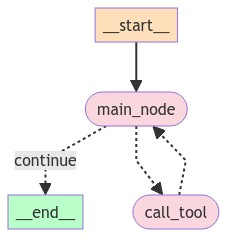

In [49]:
workflow = StateGraph(AgentState)
workflow.add_node("main_node", main_node)
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "main_node",
    router,
    {"continue": END, "call_tool": "call_tool"},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "main_node": "main_node"
    },
)

workflow.set_entry_point("main_node")
graph = workflow.compile()


#DRAW GRAPH
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


    
def run(input_message):
   
    for s in graph.stream(input_message, {"recursion_limit": 20}):
        print("AGENT:", s)
        agent = list(s.keys())[0]
        content = s[agent]["messages"][-1].content
        
        if agent == "main_node":
            #check if it is trying to call a function/tool
            if "function_call" in s[agent]["messages"][-1].additional_kwargs:
                function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
                args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
                content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
                content = Markdown(content)
                md(content)
            else:
                try:
                    content = str(json.loads(content))
                except:
                    pass
                content = Markdown(content)
                md(content)
        else:
            content = Markdown(content)
            md(content)
            
    return   s[agent]["messages"][-1].content
    

In [50]:
with open('Data/new_chirag/algorithm_problems_using_python__178__06_03_2024_15_46_55_1.ipynb', 'r') as file:
    convo= file.read()

input_message = {
    "chat_history": [],
    "messages": [HumanMessage((f"Conversation between AI Assistant and a human User: \n {convo}"))],
    "user_config": {},
}


result =  run(input_message)

AGENT: {'main_node': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "code": "import numpy as np\\n\\n\\ndef principal_component_analysis(X, num_components, standardize=True):\\n    try:\\n        # Input validation\\n        if not isinstance(X, np.ndarray):\\n            raise TypeError(\\"Input data must be a numpy.ndarray!\\")\\n        if len(X.shape) != 2:\\n            raise ValueError(\\"Input data must be a 2D array!\\")\\n        if not isinstance(num_components, int):\\n            raise TypeError(\\"Number of components must be an integer!\\")\\n        if num_components <= 0:\\n            raise ValueError(\\"Number of components must be greater than 0!\\")\\n        if num_components > X.shape[1]:\\n            raise ValueError(\\"Number of components must be less than or equal to number of features!\\")\\n\\n        # Standardizing the dataset (optional) and always centering\\n        mean = np.mean(X, axis=0)\\n        if stan

I am calling the function functions with the following arguments: { "code": "import numpy as np\n\n\ndef           
principal_component_analysis(X, num_components, standardize=True):\n    try:\n        # Input validation\n         
if not isinstance(X, np.ndarray):\n            raise TypeError("Input data must be a numpy.ndarray!")\n        if  
len(X.shape) != 2:\n            raise ValueError("Input data must be a 2D array!")\n        if not                 
isinstance(num_components, int):\n            raise TypeError("Number of components must be an integer!")\n        
if num_components <= 0:\n            raise ValueError("Number of components must be greater than 0!")\n        if  
num_components > X.shape[1]:\n            raise ValueError("Number of components must be less than or equal to     
number of features!")\n\n        # Standardizing the dataset (optional) and always centering\n        mean =       
np.mean(X, axis=0)\n        if standardize:\n            std_dev = np.std(X, axis=0, ddof=1)\n            X = (X - 
mean) / std_dev\n        else:\n            X = X - mean\n\n        # Calculate the covariance matrix\n            
covariance_matrix = np.cov(X, rowvar=False) # rowvar=False means that columns represent variables\n\n\n        #   
Compute the eigenvalues and eigenvectors of the covariance matrix\n        eigenvalues, eigenvectors =             
np.linalg.eig(covariance_matrix)\n        if np.iscomplexobj(eigenvalues):\n            raise ValueError("Complex  
eigenvalues encountered. PCA might not be suitable for this dataset!")\n\n        # Sort eigenvectors by their     
associated eigenvalues in descending order\n        idx = np.argsort(eigenvalues)[::-1]\n        eigenvalues =     
eigenvalues[idx]\n        # Align eigenvectors with sorted eigenvalues\n        eigenvectors = eigenvectors[:,     
idx]\n\n        # Select the first num_components eigenvectors\n        eigenvectors = eigenvectors[:,             
:num_components]\n\n        # Transform the original matrix by projecting data onto principal components\n         
X_pca = np.dot(X, eigenvectors)\n\n        total_variance = np.sum(eigenvalues)\n        explained_variance =      
eigenvalues[:num_components] / total_variance\n\n        return X_pca, explained_variance\n\n    except TypeError  
as te:\n        print(f"TypeError: {te}")\n        return None\n    except ValueError as ve:\n                     
print(f"ValueError: {ve}")\n        return None\n\n\nnp.random.seed(42)\nX = np.random.randn(500, 6)  # Simulated  
data\n\n# Specify the number of components\nnum_components = 2\n\n# Perform PCA with standardization and get the   
transformed data and variance explained\ntransformed_data, explained_variance = principal_component_analysis(X,    
num_components, standardize=True)\n\nif transformed_data is not None and explained_variance is not None:\n         
print("Original data shape: ", X.shape)\n    print("Transformed data shape: ", transformed_data.shape)\n           
print("Variance explained by each principal component: ", explained_variance)\nelse:\n    print("PCA computation   
failed.")" }

AGENT: {'call_tool': {'messages': [FunctionMessage(content='functions response: functions is not a valid tool, try one of [tavily_search_results_json, python_repl].', name='functions')]}}


functions response: functions is not a valid tool, try one of [tavily_search_results_json, python_repl].

AGENT: {'main_node': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "code": "import numpy as np\\n\\n\\ndef principal_component_analysis(X, num_components, standardize=True):\\n    try:\\n        # Input validation\\n        if not isinstance(X, np.ndarray):\\n            raise TypeError(\\"Input data must be a numpy.ndarray!\\")\\n        if len(X.shape) != 2:\\n            raise ValueError(\\"Input data must be a 2D array!\\")\\n        if not isinstance(num_components, int):\\n            raise TypeError(\\"Number of components must be an integer!\\")\\n        if num_components <= 0:\\n            raise ValueError(\\"Number of components must be greater than 0!\\")\\n        if num_components > X.shape[1]:\\n            raise ValueError(\\"Number of components must be less than or equal to number of features!\\")\\n\\n        # Standardizing the dataset (optional) and always centering\\n        mean = np.mean(X, axis=0)\\n        if stan

I am calling the function python_repl with the following arguments: { "code": "import numpy as np\n\n\ndef         
principal_component_analysis(X, num_components, standardize=True):\n    try:\n        # Input validation\n         
if not isinstance(X, np.ndarray):\n            raise TypeError("Input data must be a numpy.ndarray!")\n        if  
len(X.shape) != 2:\n            raise ValueError("Input data must be a 2D array!")\n        if not                 
isinstance(num_components, int):\n            raise TypeError("Number of components must be an integer!")\n        
if num_components <= 0:\n            raise ValueError("Number of components must be greater than 0!")\n        if  
num_components > X.shape[1]:\n            raise ValueError("Number of components must be less than or equal to     
number of features!")\n\n        # Standardizing the dataset (optional) and always centering\n        mean =       
np.mean(X, axis=0)\n        if standardize:\n            std_dev = np.std(X, axis=0, ddof=1)\n            X = (X - 
mean) / std_dev\n        else:\n            X = X - mean\n\n        # Calculate the covariance matrix\n            
covariance_matrix = np.cov(X, rowvar=False) # rowvar=False means that columns represent variables\n\n\n        #   
Compute the eigenvalues and eigenvectors of the covariance matrix\n        eigenvalues, eigenvectors =             
np.linalg.eig(covariance_matrix)\n        if np.iscomplexobj(eigenvalues):\n            raise ValueError("Complex  
eigenvalues encountered. PCA might not be suitable for this dataset!")\n\n        # Sort eigenvectors by their     
associated eigenvalues in descending order\n        idx = np.argsort(eigenvalues)[::-1]\n        eigenvalues =     
eigenvalues[idx]\n        # Align eigenvectors with sorted eigenvalues\n        eigenvectors = eigenvectors[:,     
idx]\n\n        # Select the first num_components eigenvectors\n        eigenvectors = eigenvectors[:,             
:num_components]\n\n        # Transform the original matrix by projecting data onto principal components\n         
X_pca = np.dot(X, eigenvectors)\n\n        total_variance = np.sum(eigenvalues)\n        explained_variance =      
eigenvalues[:num_components] / total_variance\n\n        return X_pca, explained_variance\n\n    except TypeError  
as te:\n        print(f"TypeError: {te}")\n        return None\n    except ValueError as ve:\n                     
print(f"ValueError: {ve}")\n        return None\n\n\nnp.random.seed(42)\nX = np.random.randn(500, 6)  # Simulated  
data\n\n# Specify the number of components\nnum_components = 2\n\n# Perform PCA with standardization and get the   
transformed data and variance explained\ntransformed_data, explained_variance = principal_component_analysis(X,    
num_components, standardize=True)\n\nif transformed_data is not None and explained_variance is not None:\n         
print("Original data shape: ", X.shape)\n    print("Transformed data shape: ", transformed_data.shape)\n           
print("Variance explained by each principal component: ", explained_variance)\nelse:\n    print("PCA computation   
failed.")" }

AGENT: {'call_tool': {'messages': [FunctionMessage(content='python_repl response: Successfully executed:\n```python\nimport numpy as np\n\n\ndef principal_component_analysis(X, num_components, standardize=True):\n    try:\n        # Input validation\n        if not isinstance(X, np.ndarray):\n            raise TypeError("Input data must be a numpy.ndarray!")\n        if len(X.shape) != 2:\n            raise ValueError("Input data must be a 2D array!")\n        if not isinstance(num_components, int):\n            raise TypeError("Number of components must be an integer!")\n        if num_components <= 0:\n            raise ValueError("Number of components must be greater than 0!")\n        if num_components > X.shape[1]:\n            raise ValueError("Number of components must be less than or equal to number of features!")\n\n        # Standardizing the dataset (optional) and always centering\n        mean = np.mean(X, axis=0)\n        if standardize:\n            std_dev = np.std(X, ax

python_repl response: Successfully executed:                                                                       

                                                                                                                   
 import numpy as np                                                                                                
                                                                                                                   
                                                                                                                   
 def principal_component_analysis(X, num_components, standardize=True):                                            
     try:                                                                                                          
         # Input validation                                                                                        
         if not isinstance(X, np.ndarray):                                                                         
             raise TypeError("Input data must be a numpy.ndarray!")                                                
         if len(X.shape) != 2:                                                                                     
             raise ValueError("Input data must be a 2D array!")                                                    
         if not isinstance(num_components, int):                                                                   
             raise TypeError("Number of components must be an integer!")                                           
         if num_components <= 0:                                                                                   
             raise ValueError("Number of components must be greater than 0!")                                      
         if num_components > X.shape[1]:                                                                           
             raise ValueError("Number of components must be less than or equal to number of features!")            
                                                                                                                   
         # Standardizing the dataset (optional) and always centering                                               
         mean = np.mean(X, axis=0)                                                                                 
         if standardize:                                                                                           
             std_dev = np.std(X, axis=0, ddof=1)                                                                   
             X = (X - mean) / std_dev                                                                              
         else:                                                                                                     
             X = X - mean                                                                                          
                                                                                                                   
         # Calculate the covariance matrix                                                                         
         covariance_matrix = np.cov(X, rowvar=False) # rowvar=False means that columns represent variables         
                                                                                                                   
                                                                                                                   
         # Compute the eigenvalues and eigenvectors of the covariance matrix                                       
         eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)                                              
         if np.iscomplexobj(eigenvalues):                                                                          
             raise ValueError("Complex eigenvalues enco

AGENT: {'main_node': {'messages': [AIMessage(content='{\n  "scratchpad": "I have reviewed the entire conversation and the code provided by the Assistant. The code aims to implement PCA from scratch, including data standardization, computation of the covariance matrix, eigenvalue decomposition, and projection of the original dataset onto a new feature space. I ran the code with a sample dataset, and it executed successfully, producing the expected output.\\n\\nNow, I will identify issues based on the evaluation criteria: Correctness, Efficiency, Best Practices, Readability, and Consistency.",\n  "issues": [\n    {\n      "cell_position": 5,\n      "what": "Unnecessary try-except block for input validation.",\n      "why": "Using try-except blocks for input validation is not recommended because it makes the code harder to read and debug. It\'s more efficient to let Python\'s built-in error handling manage type errors and value errors.",\n      "where": "Throughout the `principal_componen

{'scratchpad': 'I have reviewed the entire conversation and the code provided by the Assistant. The code aims to   
implement PCA from scratch, including data standardization, computation of the covariance matrix, eigenvalue       
decomposition, and projection of the original dataset onto a new feature space. I ran the code with a sample       
dataset, and it executed successfully, producing the expected output.\n\nNow, I will identify issues based on the  
evaluation criteria: Correctness, Efficiency, Best Practices, Readability, and Consistency.', 'issues':            
[{'cell_position': 5, 'what': 'Unnecessary try-except block for input validation.', 'why': "Using try-except blocks
for input validation is not recommended because it makes the code harder to read and debug. It's more efficient to 
let Python's built-in error handling manage type errors and value errors.", 'where': 'Throughout the               
principal_component_analysis function.', 'severity': 'Medium', 'fix': "Remove the try-except block and rely on     
Python's built-in error handling."}, {'cell_position': 5, 'what': 'Unnecessary check for complex eigenvalues.',    
'why': 'The numpy.linalg.eig function should not return complex eigenvalues for a covariance matrix if the input   
data is real. This check adds unnecessary complexity.', 'where': 'if np.iscomplexobj(eigenvalues): raise           
ValueError("Complex eigenvalues encountered. PCA might not be suitable for this dataset!")', 'severity': 'Low',    
'fix': 'Remove the check for complex eigenvalues.'}, {'cell_position': 5, 'what': 'Hardcoded standard deviation    
degrees of freedom (ddof=1) in standardization.', 'why': 'Setting ddof=1 for standardization might not be suitable 
for all datasets. It would be better to allow this to be configurable.', 'where': 'std_dev = np.std(X, axis=0,     
ddof=1)', 'severity': 'Low', 'fix': 'Add an optional parameter to the function to configure the degrees of freedom 
for standardization.'}], 'scoring_explanation': 'The code is correct and produces the expected output, but there   
are some areas for improvement. The use of try-except blocks for input validation is not recommended, and some     
checks (like for complex eigenvalues) are unnecessary. Additionally, the hardcoded degrees of freedom for standard 
deviation in standardization could be made configurable. These issues are not critical but do affect the           
readability and efficiency of the code. Therefore, the score is rated as 3.', 'score': 3}

In [51]:
json.loads(result)

{'scratchpad': 'I have reviewed the entire conversation and the code provided by the Assistant. The code aims to implement PCA from scratch, including data standardization, computation of the covariance matrix, eigenvalue decomposition, and projection of the original dataset onto a new feature space. I ran the code with a sample dataset, and it executed successfully, producing the expected output.\n\nNow, I will identify issues based on the evaluation criteria: Correctness, Efficiency, Best Practices, Readability, and Consistency.',
 'issues': [{'cell_position': 5,
   'what': 'Unnecessary try-except block for input validation.',
   'why': "Using try-except blocks for input validation is not recommended because it makes the code harder to read and debug. It's more efficient to let Python's built-in error handling manage type errors and value errors.",
   'where': 'Throughout the `principal_component_analysis` function.',
   'severity': 'Medium',
   'fix': "Remove the try-except block an